# Mean-Variance Optimization


In [2]:
#### IMPORTS AND DATA LOADING ####

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

multi_asset_data = pd.ExcelFile("multi_asset_etf_data.xlsx")
# multi_asset_data.sheet_names # Sheets are ['descriptions', 'prices', 'total returns', 'excess returns']
prices = multi_asset_data.parse("prices", index_col=0, parse_dates=True)
excess_returns = multi_asset_data.parse(
    "excess returns", index_col=0, parse_dates=True
).drop(columns=["QAI"])
total_returns = multi_asset_data.parse(
    "total returns", index_col=0, parse_dates=True
).drop(columns=["QAI"])

## 1. Summary Statistics


In [3]:
#### SUMMARY STATISTICS ####

means = excess_returns.mean() * 12
vols = excess_returns.std() * np.sqrt(12)
sharpe_ratios = means / vols
summary_stats = pd.DataFrame(
    {"Mean": means, "Volatility": vols, "Sharpe Ratio": sharpe_ratios}
)

display(summary_stats.round(4).sort_values(by="Sharpe Ratio", ascending=False))
print(
    f"Best Sharpe: {summary_stats['Sharpe Ratio'].idxmax()} with {summary_stats['Sharpe Ratio'].max():.4f}"
)
print(
    f"Worst Sharpe: {summary_stats['Sharpe Ratio'].idxmin()} with {summary_stats['Sharpe Ratio'].min():.4f}"
)

,Mean,Volatility,Sharpe Ratio
SPY,0.1281,0.1428,0.8971
HYG,0.0414,0.0759,0.5449
IYR,0.0749,0.1687,0.4441
PSP,0.0926,0.2134,0.4338
EFA,0.0618,0.1509,0.4094
TIP,0.0205,0.0511,0.4011
IEF,0.0164,0.0634,0.2586
EEM,0.0293,0.1762,0.1665
DBC,-0.0053,0.1666,-0.0318
BWX,-0.0077,0.0828,-0.0932


Best Sharpe: SPY with 0.8971
Worst Sharpe: BWX with -0.0932


### Best Sharpe: SPY with 0.8971

### Worst Sharpe: BWX with -0.0932


## 2. Descriptive Analysis


Pair with highest correlation: ('EFA', 'PSP') with 0.8953
Pair with lowest correlation: ('DBC', 'IEF') with -0.3002
TIP (excess) returns: 0.0205
IEF (excess) returns: 0.0164
BWX (excess) returns: -0.0077


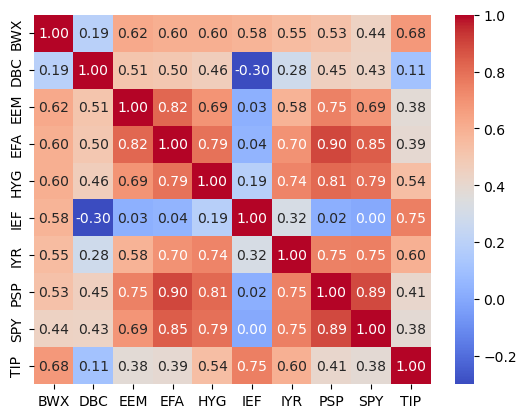

In [4]:
#### CORRELATION ANALYSIS ####

import seaborn as sns

corrs = excess_returns.corr()
sns.heatmap(corrs, annot=True, fmt=".2f", cmap="coolwarm")
unique = corrs.where(np.triu(np.ones(corrs.shape), k=1).astype(bool)).stack()
ma = unique.idxmax(), unique.max()
mi = unique.idxmin(), unique.min()
print(f"Pair with highest correlation: {ma[0]} with {ma[1]:.4f}")
print(f"Pair with lowest correlation: {mi[0]} with {mi[1]:.4f}")
print(f"TIP (excess) returns: {means['TIP']:.4f}")
print(f"IEF (excess) returns: {means['IEF']:.4f}")
print(f"BWX (excess) returns: {means['BWX']:.4f}")

- The pair with the highest correlation is EFA and PSP with 0.8953, which suggests that global private equity companies and large corporations in (non-US) developed nations are highly correlated. The pair with the lowest correlation is HYG and IEF with -0.0491, which suggests that commodities and 7-10Y TBonds are not very correlated.

- TIP outperformed domestic bonds (IEF) and international bonds (BWX) on an excess return basis over the sample period.

<div align="center">

| Asset | Excess Return |
| ----- | ------------- |
| TIP   | 0.0205        |
| IEF   | 0.0164        |
| BWX   | -0.0077       |

</div>


## 3. The MV Frontier


In [5]:
sigma = (excess_returns.cov()).to_numpy()
mu = (excess_returns.mean()).to_numpy().reshape(-1, 1)
inv_sigma = np.linalg.inv(sigma)
w_tan = (inv_sigma @ mu).flatten()
w_tan /= np.sum(w_tan)
display(
    pd.DataFrame({"Weight": w_tan, "Sharpe": sharpe_ratios})
    .sort_values(by="Weight", ascending=False)
    .round(4)
)

# mean of portfolio
mean_p = (w_tan @ mu).item() * 12
# vol of portfolio
vol_p = ((w_tan @ sigma @ w_tan).item() * 12) ** 0.5
sharpe_p = mean_p / vol_p

,Weight,Sharpe
SPY,1.0596,0.8971
IEF,0.8812,0.2586
HYG,0.2906,0.5449
TIP,0.1753,0.4011
EFA,0.0687,0.4094
EEM,0.0264,0.1665
DBC,-0.0716,-0.0318
IYR,-0.2466,0.4441
PSP,-0.3330,0.4338
BWX,-0.8506,-0.0932


In [6]:
# mean of portfolio
mean_p = (w_tan @ mu).item() * 12
# vol of portfolio
vol_p = ((w_tan @ sigma @ w_tan).item() * 12) ** 0.5
sharpe_p = mean_p / vol_p
# sharpe_ratios = means / vols

weights = pd.DataFrame(
    {"Weight": w_tan, "Sharpe": sharpe_ratios[excess_returns.columns]}
).sort_values(by="Weight", ascending=False)
print(weights)

# print(mean_p, vol_p, sharpe_p)

print(
    f"Tangency Portfolio Sharpe Ratio: {sharpe_p:.4f} with mean excess return {mean_p:.4f} and volatility {vol_p:.4f}"
)

       Weight    Sharpe
SPY  1.059632  0.897103
IEF  0.881186  0.258569
HYG  0.290614  0.544873
TIP  0.175293  0.401091
EFA  0.068682  0.409372
EEM  0.026437  0.166542
DBC -0.071623 -0.031774
IYR -0.246582  0.444143
PSP -0.332995  0.433804
BWX -0.850643 -0.093202
Tangency Portfolio Sharpe Ratio: 1.4692 with mean excess return 0.1285 and volatility 0.0875


## 4. TIPS

### 4.1 TIPS dropped from investment set


In [7]:
# excess_returns_no_tips
ernt = excess_returns.drop(columns=["TIP"])
sigma = (ernt.cov()).to_numpy()
mu = (ernt.mean()).to_numpy().reshape(-1, 1)
inv_sigma = np.linalg.inv(sigma)
w_tan = (inv_sigma @ mu).flatten()
w_tan /= np.sum(w_tan)
weights = pd.DataFrame({"Weight": w_tan, "Sharpe": sharpe_ratios[ernt.columns]})
print(weights)
# mean of portfolio
mean_p = (w_tan @ mu).item() * 12
# vol of portfolio
vol_p = ((w_tan @ sigma @ w_tan).item() * 12) ** 0.5
sharpe_p = mean_p / vol_p

print(
    f"Tangency Portfolio (no TIP) Sharpe Ratio: {sharpe_p:.4f} with mean excess return {mean_p:.4f} and volatility {vol_p:.4f}"
)

       Weight    Sharpe
BWX -0.879292 -0.093202
DBC -0.063742 -0.031774
EEM  0.032493  0.166542
EFA  0.060153  0.409372
HYG  0.316300  0.544873
IEF  1.019957  0.258569
IYR -0.247445  0.444143
PSP -0.339398  0.433804
SPY  1.100973  0.897103
Tangency Portfolio (no TIP) Sharpe Ratio: 1.4675 with mean excess return 0.1327 and volatility 0.0905


### 4.2 TIPS excess returns increased by 0.0012


In [8]:
erit = excess_returns.copy()
erit["TIP"] += 0.0012
sigma = (erit.cov()).to_numpy()
mu = (erit.mean()).to_numpy().reshape(-1, 1)
inv_sigma = np.linalg.inv(sigma)
w_tan = (inv_sigma @ mu).flatten()
w_tan /= np.sum(w_tan)
weights = pd.DataFrame({"Weight": w_tan, "Sharpe": sharpe_ratios[erit.columns]})
print(weights)
# mean of portfolio
mean_p = (w_tan @ mu).item() * 12
# vol of portfolio
vol_p = ((w_tan @ sigma @ w_tan).item() * 12) ** 0.5
sharpe_p = mean_p / vol_p

print(
    f"Tangency Portfolio (with increased TIP) Sharpe Ratio: {sharpe_p:.4f} with mean excess return {mean_p:.4f} and volatility {vol_p:.4f}"
)

       Weight    Sharpe
BWX -0.669693 -0.093202
DBC -0.121397 -0.031774
EEM -0.011815  0.166542
EFA  0.122554  0.409372
HYG  0.128372  0.544873
IEF  0.004667  0.258569
IYR -0.241132  0.444143
PSP -0.292555  0.433804
SPY  0.798513  0.897103
TIP  1.282487  0.401091
Tangency Portfolio (with increased TIP) Sharpe Ratio: 1.6124 with mean excess return 0.1204 and volatility 0.0746


    Sharpe ratio of full investment set was 1.4692 (mean 12.85%, vol 8.75%). With TIP removed, sharpe was 1.4675 (mean 13.27 % and volatility 9.05%). Finally, with TIP excess returns increased by 0.0012, sharpe was 1.6124 (mean 12.04%, vol 7.47%). Thus, removing TIP had a negligible effect on the investment set and considering TIP as its own asset class may not be necessary.


## 3. Allocations


In [9]:
# Equally-Weighted (EW) Portfolio
w_ew = np.ones(len(excess_returns.columns)) / len(excess_returns.columns)

# Risk Parity (RP) Portfolio
w_rp = (w_rp := 1 / excess_returns.var()) / w_rp.sum()

# Mean-Variance Optimal (MV) Portfolio
w_mv = (
    w_mv := (inv_sigma := np.linalg.inv(excess_returns.cov().to_numpy())) @ means
) / w_mv.sum()

# target mean: µ = 0.01 (monthly)
target_mean = 0.01

# Rescaled weights
w_ew_r = (w_ew := w_ew * target_mean / (w_ew @ excess_returns.mean()))
w_rp_r = (w_rp := w_rp * target_mean / (w_rp @ excess_returns.mean()))
w_mv_r = (w_mv := w_mv * target_mean / (w_mv @ excess_returns.mean()))

weights = pd.DataFrame(
    {
        "EW": w_ew_r,
        "RP": w_rp_r,
        "MV": w_mv_r,
        "Sharpe": sharpe_ratios[excess_returns.columns],
    }
).sort_values(by="MV", ascending=False)
print(weights)

# print(f"EW weights:\n{pd.DataFrame({'Weight': w_ew}, index=excess_returns.columns)}")
# print(f"RP weights:\n{pd.DataFrame({'Weight': w_rp}, index=excess_returns.columns)}")
# print(f"MV weights:\n{pd.DataFrame({'Weight': w_mv}, index=excess_returns.columns)}")

# # sanity check (all portfolios should have mean return of 0.01
# print(f"EW mean: {w_ew @ excess_returns.mean():.4f}")
# print(f"RP mean: {w_rp @ excess_returns.mean():.4f}")
# print(f"MV mean: {w_mv @ excess_returns.mean():.4f}")

           EW        RP        MV    Sharpe
SPY  0.265486  0.181600  0.989382  0.897103
IEF  0.265486  0.920577  0.822766  0.258569
HYG  0.265486  0.642698  0.271347  0.544873
TIP  0.265486  1.418104  0.163671  0.401091
EFA  0.265486  0.162710  0.064129  0.409372
EEM  0.265486  0.119392  0.024684  0.166542
DBC  0.265486  0.133569 -0.066874 -0.031774
IYR  0.265486  0.130229 -0.230235  0.444143
PSP  0.265486  0.081385 -0.310919  0.433804
BWX  0.265486  0.540585 -0.794248 -0.093202


In [10]:
# Compute portfolio performance

def portfolio_stats(weights, excess_returns):
    mean_r = (weights @ excess_returns.mean()) * 12   # annualized mean
    vol_r  = np.sqrt(weights @ excess_returns.cov().values @ weights) * np.sqrt(12)  # annualized vol
    sharpe = mean_r / vol_r
    return mean_r, vol_r, sharpe

for name, w in zip(["EW", "RP", "MV"], [w_ew_r, w_rp_r, w_mv_r]):
    m, v, s = portfolio_stats(w, excess_returns)
    print(f"{name}: Mean={m:.4f}, Vol={v:.4f}, Sharpe={s:.4f}")


EW: Mean=0.1200, Vol=0.2692, Sharpe=0.4457
RP: Mean=0.1200, Vol=0.2639, Sharpe=0.4547
MV: Mean=0.1200, Vol=0.0817, Sharpe=1.4692


By construction, all three portfolios achieve the same mean excess return of 0.12. However, their variances differ significantly: the Mean-Variance portfolio exhibits the lowest volatility, which results in a Sharpe ratio far exceeding that of the Equally Weighted and Risk Parity portfolios. Overall, the MV portfolio demonstrates substantial efficiency gains in the risk–return trade-off.